In [1]:
import csv
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from subprocess import check_output
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error

print(check_output(["ls", "/Users/Hermione/MasterUCL/Web economics/Assignment/dataset"]).decode("utf8"))

cleantest.csv
cleantrain.csv
cleanvalidation.csv
square_bid.csv
test.csv
train.csv
train_data.csv
val_data.csv
validation.csv



In [2]:
xtrain = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/train_data.csv")
xvalidation = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/val_data.csv")

In [3]:
xtrain.columns

Index(['Unnamed: 0', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8',
       ...
       'usertag_13874', 'usertag_14273', 'usertag_15398', 'usertag_16593',
       'usertag_16617', 'usertag_16661', 'usertag_16706', 'usertag_16751',
       'usertag_16753', 'usertag_null'],
      dtype='object', length=185)

In [4]:
len(xtrain.columns)

185

In [5]:
train = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/train.csv")
validation = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/validation.csv")

ytrain = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/train.csv")["click"]
yvalidation = pd.read_csv("/Users/Hermione/MasterUCL/Web economics/Assignment/dataset/validation.csv")["click"]

# this correct the missing columns in validation and test data set due to I encoded them seperately
def MissingColumnsCorrector(df1,df2):
    for columns in df1:
        if columns in df2:
            continue
        else:
            missing_columns = columns
            ind = df1.columns.get_loc(missing_columns)
            df2.insert(ind,missing_columns,0.0)
    return df2


xvalidation = MissingColumnsCorrector(xtrain,xvalidation)

xtrain = np.array(xtrain)
ytrian = np.array(ytrain)
ytrain = [int(numeric_string) for numeric_string in ytrain]
xvalidation = np.array(xvalidation)
yvalidation = np.array(yvalidation)
yvalidation = [int(numeric_string) for numeric_string in yvalidation]

In [ ]:
#Dont run GBDT on Jupyter unless you want to wait forever!!! Use the index I provided in next cell directly.
gbdt = GradientBoostingClassifier()
gbdt.fit(xtrain, ytrain)
feature_importance = gbdt.feature_importances_
print(feature_importance)

print(gbdt.feature_importances_.shape)


index = np.where(feature_importance > 0)
index = list(index[0])
print(len(index))

import csv

with open('importantFeatureIndCombined', 'w') as myfile:
    wr = csv.writer(myfile,  dialect='excel')
    wr.writerow(index)


In [6]:
index = [0,32,33,35,37,38,40,44,51,60,73,85,88,95,100,104,107,111,112,116,118,123,157,158,159,160,161,168,174,175,176,180]
print("The number of important feature is:",len(index))

The number of important feature is: 32


In [7]:
#generate new train data and validation data with only important features
new_train = xtrain[:, index]
new_val = xvalidation[:, index]

In [28]:
#model = LogisticRegression(class_weight = "balanced")
#trainedlr = model.fit(new_train,ytrain)

In [8]:
optimalmodel = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
trainedlr = optimalmodel.fit(new_train,ytrain)

In [9]:
prob = trainedlr.predict_proba(new_val)

pClick = pd.DataFrame(prob)
predicty = trainedlr.predict(new_val)
precision = precision_score(yvalidation, predicty, average='micro')
correctpred = sum(predicty == yvalidation)



In [10]:
print("lr model predicted",correctpred,"correct click status")
print("The precision of lr model is",precision)
print(pClick)

lr model predicted 257692 correct click status
The precision of lr model is 0.859692609483
               0         1
0       0.754624  0.245376
1       0.157002  0.842998
2       0.455642  0.544358
3       0.506827  0.493173
4       0.607348  0.392652
5       0.512483  0.487517
6       0.455642  0.544358
7       0.607348  0.392652
8       0.879713  0.120287
9       0.539993  0.460007
10      0.532785  0.467215
11      0.461261  0.538739
12      0.774483  0.225517
13      0.248632  0.751368
14      0.809191  0.190809
15      0.754624  0.245376
16      0.607348  0.392652
17      0.565701  0.434299
18      0.763783  0.236217
19      0.701777  0.298223
20      0.607347  0.392653
21      0.607347  0.392653
22      0.815462  0.184538
23      0.831683  0.168317
24      0.807519  0.192481
25      0.721239  0.278761
26      0.693003  0.306997
27      0.797415  0.202585
28      0.629409  0.370591
29      0.754624  0.245376
...          ...       ...
299719  0.931501  0.068499
299720  0.904414  

In [11]:
# apply negative downsampling to work out weights in order for probability of click to have the same ratio as training data, technique is called 
#model recalibration  
temp = len(train) / (2 * np.bincount(train.click))
w = temp[0]/temp[1]
print(w)

prob =[]
for p in pClick[1]:
    prob.append( p / (p + ((1-p)/w)))
prob[:5]

0.000754533880574


[0.00024528674235665114,
 0.0040350161142807808,
 0.00090063278308184021,
 0.00073366659655097594,
 0.00048757093091907901]

In [12]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve([click for click in validation.click], prob)
print('AUC accuracy:',metrics.auc(fpr, tpr))

AUC accuracy: 0.813801067591


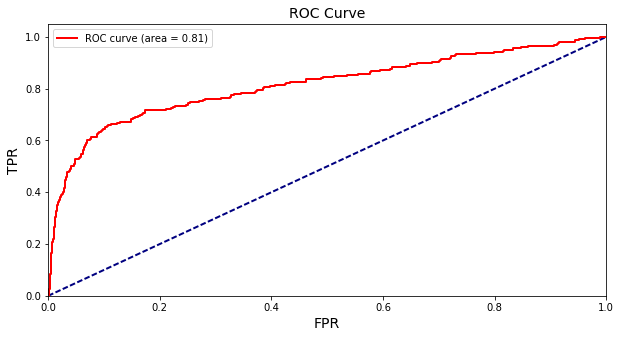

In [33]:
fig1 = plt.subplots(figsize =(10,5))
lw = 2
plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr,tpr,color = 'r', lw=lw, label='ROC curve (area = %0.2f)' %metrics.auc(fpr, tpr))
plt.legend(loc='best')

plt.show()

# ORTB non-linear

In [13]:
lambdas = [5.2e-10,5.2e-9,5.2e-8,5.2e-7,5.2e-6,5.2e-5,5.2e-4,5.2e-3,5.2e-2,5.2e-1]
c = np.arange(10,101,10).tolist()
combinations = list(itertools.product(c, lambdas))

In [14]:
def ortb1(c,lambdas):
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 2500000  # 1/10th budget of 25,000,000
    bidortb1 = []
    
    for pctr in Combinedctr:
        ortb = math.sqrt(c/lambdas*pctr + c**2)-c
        bidortb1.append(ortb)
    
    true_bids = bidortb1 >= validation.payprice
    for i in range(0, len(true_bids)):
        if true_bids[i] == True:
            impression += 1.0
            clicks += validation.click[i]
            cost += validation.payprice[i]
        if cost >= budget:
            break
    return impression, clicks, cost

In [15]:
def get_results(ortb):
    df = pd.DataFrame()
    
    imp = []
    clik = []
    ct = []
    clamb = []
    for combination in combinations:
        c = combination[0]
        lam = combination[1]
        [imps, clicks, cost] = ortb(c,lam)
        imp.append(imps)
        clik.append(clicks)
        ct.append(cost)
        clamb.append(combination)
    df['C_Lambda'] = clamb
    df['impressions'] = imp
    df['total_cost'] = ct
    df['clicks'] = clik
    df['CTR'] = (df.clicks / df.impressions * 100).round(2).astype(str)
    df['CPM'] = (df.total_cost / df.impressions * 1000).round(2).astype(str)
    df['CPC'] = (df.total_cost / df.clicks).round(2).astype(str)
    return df



In [17]:
Combinedctr = np.asarray(prob)

In [38]:
ortb1result = get_results(ortb1)

In [39]:
ortb1result.sort_values("clicks",ascending = False)[:10]


,C_Lambda,impressions,total_cost,clicks,CTR,CPM,CPC
94,"(100, 5.2e-06)",71583.0,2364543.0,130,0.18,33032.19,18188.79
84,"(90, 5.2e-06)",70625.0,2301284.0,129,0.18,32584.55,17839.41
74,"(80, 5.2e-06)",69301.0,2222381.0,127,0.18,32068.53,17499.06
64,"(70, 5.2e-06)",67618.0,2124563.0,124,0.18,31420.08,17133.57
54,"(60, 5.2e-06)",65819.0,2021950.0,121,0.18,30719.85,16710.33
44,"(50, 5.2e-06)",62710.0,1869840.0,115,0.18,29817.25,16259.48
34,"(40, 5.2e-06)",59391.0,1692778.0,112,0.19,28502.26,15114.09
24,"(30, 5.2e-06)",55190.0,1470283.0,100,0.18,26640.39,14702.83
14,"(20, 5.2e-06)",48580.0,1170331.0,94,0.19,24090.8,12450.33
4,"(10, 5.2e-06)",38046.0,783878.0,73,0.19,20603.43,10738.05


# Squared bidding

In [18]:
# calculate squared bidding
averageCTR = (train.click.sum() / train.logtype.sum())
print(averageCTR)# this is the average CTR for training data

base_bids = np.arange(10,300,5) #self defined base bids

square_bids = []
for i in base_bids:
        square_bid = i * (((Combinedctr / averageCTR))**2)
        square_bids.append(square_bid)

segments_square = [square_bids[x:x+len(pClick)] for x in range(0, len(square_bids), len(pClick))] # lump all possible bids according to base bids in segments together
print(square_bids[:5])
def square_bids(bids):
    impression = 0.0
    clicks = 0
    cost = 0.0


    budget = 2500000 # 1/10 budget of 25,000,000

    true_bids = bids >= validation.payprice
    for i in range(0, len(true_bids)):
        if true_bids[i] == True:
            impression += 1.0
            clicks += validation.click[i]
            cost += validation.payprice[i]
        if cost >= budget:
            break
    return impression, clicks, cost

df2 = pd.DataFrame()
df2['bid'] = base_bids


imp = []
clik = []
ct = []


for bids in segments_square[0]:
    [imps, clicks, cost] = square_bids(bids)
    imp.append(imps)
    clik.append(clicks)
    ct.append(cost)
df2['impressions'] = imp
df2['total_cost'] = ct
df2['clicks'] = clik
df2['CTR'] = (df2.clicks / df2.impressions * 100).round(2).astype(str)
df2['CPM'] = (df2.total_cost / df2.impressions * 1000).round(2).astype(str)
df2['CPC'] = (df2.total_cost / df2.clicks).round(2).astype(str)

0.0007539649884458758
[array([   1.05839016,  286.41000743,   14.26898706, ...,    3.54900623,
          2.35470221,    0.64989436]), array([   1.58758524,  429.61501115,   21.40348059, ...,    5.32350935,
          3.53205332,    0.97484153]), array([   2.11678031,  572.82001486,   28.53797412, ...,    7.09801246,
          4.70940442,    1.29978871]), array([   2.64597539,  716.02501858,   35.67246765, ...,    8.87251558,
          5.88675553,    1.62473589]), array([   3.17517047,  859.23002229,   42.80696118, ...,   10.6470187 ,
          7.06410663,    1.94968307])]


In [41]:
df2.sort_values("clicks",ascending =False)[:10]

,bid,impressions,total_cost,clicks,CTR,CPM,CPC
7,45,41688.0,2378768.0,142,0.34,57061.22,16751.89
6,40,38752.0,2213296.0,141,0.36,57114.37,15697.13
5,35,35715.0,2054529.0,139,0.39,57525.66,14780.78
4,30,32906.0,1919624.0,135,0.41,58336.6,14219.44
3,25,29865.0,1751835.0,134,0.45,58658.46,13073.4
8,50,46046.0,2500129.0,134,0.29,54296.33,18657.68
2,20,26117.0,1532561.0,129,0.49,58680.59,11880.32
9,55,46224.0,2500054.0,126,0.27,54085.63,19841.7
1,15,22340.0,1292641.0,124,0.56,57862.18,10424.52
11,65,46622.0,2500037.0,119,0.26,53623.55,21008.71


In [42]:
df2.sort_values("clicks",ascending = False)[:10].to_csv("dataset/square_bid.csv")

In [19]:
#optimised lr
df2.sort_values("clicks",ascending =False)[:10]

,bid,impressions,total_cost,clicks,CTR,CPM,CPC
7,45,40880.0,2273728.0,142,0.35,55619.57,16012.17
6,40,38530.0,2159828.0,141,0.37,56055.75,15317.93
8,50,47186.0,2500068.0,140,0.3,52983.26,17857.63
5,35,35539.0,2007967.0,137,0.39,56500.38,14656.69
3,25,29313.0,1688318.0,132,0.45,57596.22,12790.29
4,30,32724.0,1858539.0,132,0.4,56794.37,14079.84
2,20,25701.0,1485155.0,129,0.5,57785.88,11512.83
9,55,47084.0,2500138.0,128,0.27,53099.52,19532.33
1,15,21646.0,1226661.0,121,0.56,56669.18,10137.69
10,60,47226.0,2500007.0,120,0.25,52937.09,20833.39
